# Lesson 7 — Kernels and the Kernel Trick  

## Important context
This lesson is **conceptually heavy but geometrically grounded**.

- No new optimization machinery
- Same SVM objective as Lesson 6
- New idea: implicitly mapping data to higher dimensions
- Kernels let us do this **without ever computing the mapping**

This lesson directly builds on Lesson 6.


## Outline
1. Motivation: non-linearly separable data  
2. Feature mappings and why they explode  
3. The Kernel Trick  
4. Common kernels (Linear, Polynomial, RBF)  
5. Kernelized decision function  
6. Visualizing kernel decision regions  
7. Why kernels work (geometric intuition)


## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

## 1. Motivation: when linear SVM fails

A linear SVM learns:
$$
f(x) = w^T x + b
$$

If the classes are not linearly separable in input space, no choice of \(w, b\) can fix this.

Idea:
> What if the data *is* separable after a transformation?


## 2. A simple non-linear dataset

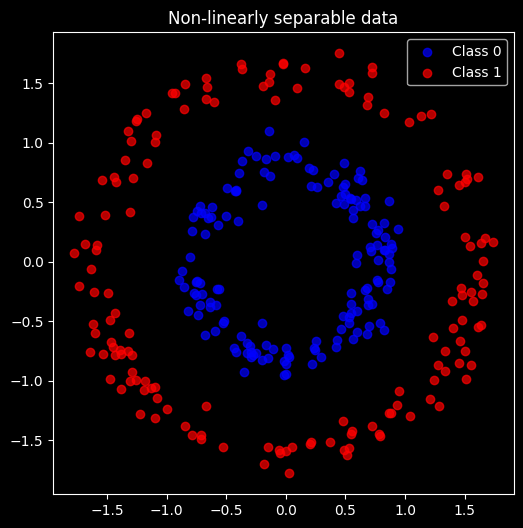

In [2]:
# Concentric circles dataset
n = 300
angles = 2 * np.pi * np.random.rand(n)
r_inner = 0.8 + 0.1 * np.random.randn(n//2)
r_outer = 1.6 + 0.1 * np.random.randn(n//2)

X_inner = np.c_[r_inner * np.cos(angles[:n//2]),
                r_inner * np.sin(angles[:n//2])]
X_outer = np.c_[r_outer * np.cos(angles[n//2:]),
                r_outer * np.sin(angles[n//2:])]

X = np.vstack([X_inner, X_outer])
y01 = np.array([0]*(n//2) + [1]*(n//2))
y = np.where(y01==1, 1, -1)

plt.figure(figsize=(6,6))
plt.scatter(X[y01==0,0], X[y01==0,1], color="blue", alpha=0.7, label="Class 0")
plt.scatter(X[y01==1,0], X[y01==1,1], color="red", alpha=0.7, label="Class 1")
plt.gca().set_aspect("equal")
plt.title("Non-linearly separable data")
plt.legend()
plt.show()

## 3. Explicit feature mapping (intuition)

Consider mapping:
$$
\phi(x) = [x_1, x_2, x_1^2 + x_2^2]
$$

In this space:
- inner circle → small radius
- outer circle → large radius

A linear separator **does exist**.


## 4. Why explicit mappings are bad

Explicit feature maps:
- grow very quickly in dimension
- are expensive to compute
- make optimization harder

But notice:
> SVMs only use **dot products** between points.

This observation leads to the kernel trick.


## 5. The Kernel Trick

A kernel is a function:
$$
K(x, z) = \phi(x)^T \phi(z)
$$

We never compute $\phi(x)$.
We only compute **inner products in feature space**.

As long as \(K\) is valid (Mercer’s condition), this works.


## 6. Common kernels

**Linear**
$$
K(x,z) = x^T z
$$

**Polynomial**
$$
K(x,z) = (x^T z + c)^d
$$

**RBF (Gaussian)**
$$
K(x,z) = \exp\left(-\frac{\|x-z\|^2}{2\sigma^2}\right)
$$

RBF creates **localized similarity**, leading to highly flexible boundaries.


## 7. Kernelized SVM (dual form intuition)

In the dual, the decision function becomes:

$$
f(x) = \sum_i \alpha_i y^{(i)} K(x^{(i)}, x) + b
$$

Key consequences:
- No explicit \(w\)
- Prediction depends only on **support vectors**
- Geometry is controlled entirely by the kernel


## 8. Simple kernelized classifier (RBF)

In [3]:
def rbf_kernel(X, Z, sigma=0.5):
    X_norm = np.sum(X**2, axis=1).reshape(-1,1)
    Z_norm = np.sum(Z**2, axis=1).reshape(1,-1)
    sq_dists = X_norm + Z_norm - 2 * X @ Z.T
    return np.exp(-sq_dists / (2*sigma**2))

# Very simple kernel perceptron-style classifier
alphas = np.zeros(len(X))
b = 0.0
sigma = 0.4
epochs = 10

K = rbf_kernel(X, X, sigma)

for _ in range(epochs):
    for i in range(len(X)):
        decision = np.sum(alphas * y * K[:,i]) + b
        if y[i] * decision <= 0:
            alphas[i] += 1

# Prediction
def kernel_predict(X_new):
    K_new = rbf_kernel(X, X_new, sigma)
    return np.sign((alphas * y) @ K_new)

preds = kernel_predict(X)
print("Kernel classifier accuracy:", np.mean(preds == y))

Kernel classifier accuracy: 1.0


## 9. Visualizing kernel decision regions

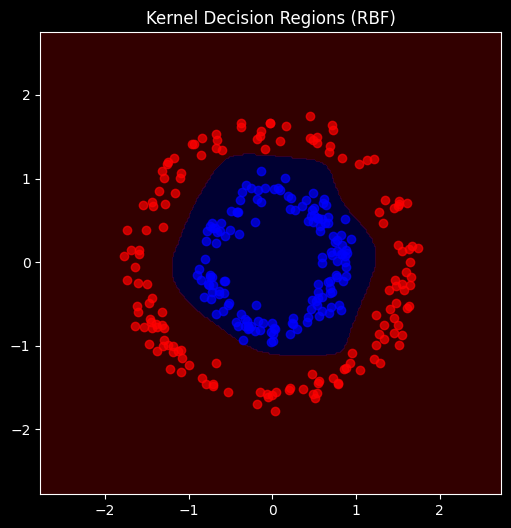

In [4]:
# Grid
x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

Z = kernel_predict(grid).reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z>0, levels=1, alpha=0.2, colors=["blue","red"])
plt.scatter(X[y01==0,0], X[y01==0,1], color="blue", alpha=0.7)
plt.scatter(X[y01==1,0], X[y01==1,1], color="red", alpha=0.7)
plt.gca().set_aspect("equal")
plt.title("Kernel Decision Regions (RBF)")
plt.show()

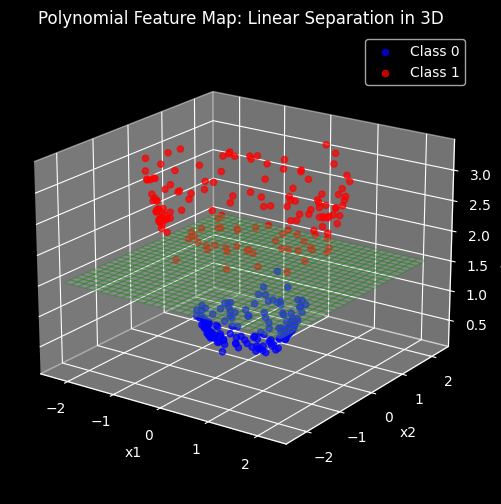

In [12]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
x1 = X[:, 0]
x2 = X[:, 1]
z = x1**2 + x2**2  # polynomial feature: radius^2

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

# Points in transformed space
ax.scatter(x1[y01==0], x2[y01==0], z[y01==0], color="blue", alpha=0.7, label="Class 0")
ax.scatter(x1[y01==1], x2[y01==1], z[y01==1], color="red",  alpha=0.7, label="Class 1")

# Pick a separating threshold between the two radii (simple + visual)
z0_max = z[y01==0].max()
z1_min = z[y01==1].min()
z_thresh = 0.5 * (z0_max + z1_min)

# Plane z = z_thresh
xx, yy = np.meshgrid(
    np.linspace(x1.min()-0.5, x1.max()+0.5, 30),
    np.linspace(x2.min()-0.5, x2.max()+0.5, 30)
)
zz = np.full_like(xx, z_thresh)

ax.plot_surface(xx, yy, zz, alpha=0.25, color="white", edgecolor="green", linewidth=1)

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x1^2 + x2^2")
ax.set_title("Polynomial Feature Map: Linear Separation in 3D")
ax.legend(loc="upper right")

# Nice camera angle (similar to your reference image)
ax.view_init(elev=20, azim=-55)

plt.show()


## 10. Geometric intuition

- Kernels bend space so linear separation becomes possible
- RBF creates a similarity-based geometry
- Decision boundary depends only on support vectors
- No explicit high-dimensional computation is required

This is why SVMs + kernels are powerful and stable.


## Key Takeaways (CS229 framing)

- Kernels implicitly map data to higher dimensions
- SVMs depend only on inner products
- The kernel trick avoids explicit feature construction
- RBF kernels create flexible, localized decision boundaries
- Next: learning theory explains *why* this generalizes well
